<a href="https://colab.research.google.com/github/hamidrg/st/blob/main/SpecialTopic_HM02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets scikit-learn pandas matplotlib seaborn torch tqdm

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import random
import gc

# تنظیم سید برای تکرارپذیری نتایج
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# بررسی دسترسی به GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Prepairing Yelp Dataset

In [3]:
import requests

url = "https://business.yelp.com/external-assets/files/Yelp-JSON.zip"
filename = "Yelp-JSON.zip"

# Adding a User-Agent header to mimic a web browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

response = requests.get(url, stream=True, headers=headers)
response.raise_for_status() # Raise an exception for HTTP errors

with open(filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=50000):
        f.write(chunk)

print(f"Downloaded {filename} successfully.")

Downloaded Yelp-JSON.zip successfully.


In [4]:
!unzip Yelp-JSON.zip
print("Extracted Yelp-JSON.zip successfully.")

Archive:  Yelp-JSON.zip
   creating: Yelp JSON/
  inflating: Yelp JSON/Yelp Dataset Documentation & ToS copy.pdf  
  inflating: __MACOSX/Yelp JSON/._Yelp Dataset Documentation & ToS copy.pdf  
  inflating: Yelp JSON/yelp_dataset.tar  
  inflating: __MACOSX/Yelp JSON/._yelp_dataset.tar  
Extracted Yelp-JSON.zip successfully.


In [5]:
!tar -xf "Yelp JSON/yelp_dataset.tar" -C .

In [6]:
!du -sh *

80K	Dataset_User_Agreement.pdf
16K	__MACOSX
55M	sample_data
114M	yelp_academic_dataset_business.json
274M	yelp_academic_dataset_checkin.json
5.0G	yelp_academic_dataset_review.json
173M	yelp_academic_dataset_tip.json
3.2G	yelp_academic_dataset_user.json
4.1G	Yelp JSON
4.1G	Yelp-JSON.zip


In [14]:
# بارگذاری داده‌ها
# به دلیل حجم بالا، ما فقط بخشی از داده‌ها را می‌خوانیم (مثلاً ۱۰۰,۰۰۰ سطر اول)
# برای استفاده از کل داده‌ها، پارامتر nrows یا chunksize را تغییر دهید
review_file = 'yelp_academic_dataset_review.json'

print("Loading data...")
try:
    # خواندن ۱۰۰ هزار خط اول برای سرعت بیشتر در این مثال
    # شما می‌توانید nrows را بردارید یا بیشتر کنید
    df = pd.read_json(review_file, lines=True, nrows=50000)
    print(f"Loaded {len(df)} reviews.")
except ValueError:
    print("Could not read file. Make sure the JSON file is correct.")

# نمایش چند نمونه
print(df[['text', 'stars']].head())

Loading data...
Loaded 50000 reviews.
                                                text  stars
0  If you decide to eat here, just be aware it is...      3
1  I've taken a lot of spin classes over the year...      5
2  Family diner. Had the buffet. Eclectic assortm...      3
3  Wow!  Yummy, different,  delicious.   Our favo...      5
4  Cute interior and owner (?) gave us tour of up...      4


In [15]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
49995,V_bNx4GEH8ChNNA0GPMrOA,_-x9v81zddshIEwRirV7kQ,GBTPC53ZrG1ZBY3DT8Mbcw,4,0,0,0,Came here first for breakfast and had their yu...,2016-10-29 00:54:49
49996,5beIdB00qToFzllb4alZNQ,VEOTasfs8zYs7grZ4C5Xfw,EQ-TZ2eeD_E0BHuvoaeG5Q,2,0,0,0,Food was good. I had a decent breakfast but no...,2017-08-09 13:12:33
49997,rjFWnq1zQTRzCyqV0jzZHw,AT_p7NkLqd50ugp3wjFg2Q,_RFqyBgklIBqOAM-zzV_WQ,3,0,1,0,It's cool that Second Image is trying. They so...,2010-07-11 21:41:35
49998,8LRFPHiso_kuCseg5BJx8A,NSCNU_j0vSdeRMIme3H0rg,8agPzX-O-8LEDjDNloSdzQ,4,1,0,1,"Best shrimp on the beach! Steamed to order, d...",2017-04-09 23:23:56


## Wordcloud

In [23]:
!pip install wordcloud

Generating WordClouds...
Positive Reviews WordCloud:


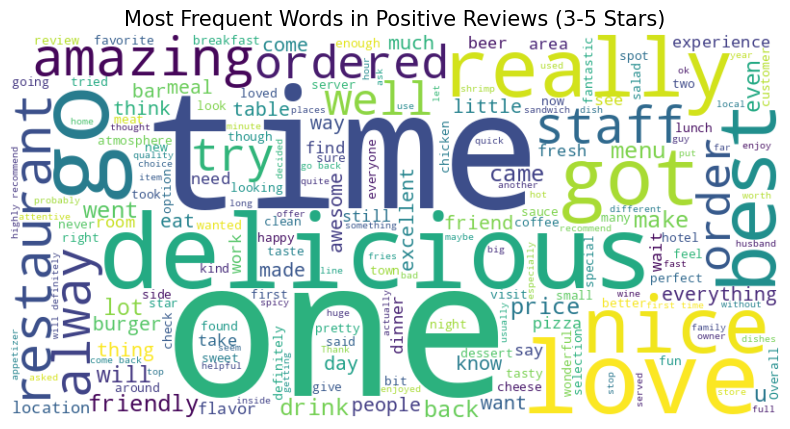

Negative Reviews WordCloud:


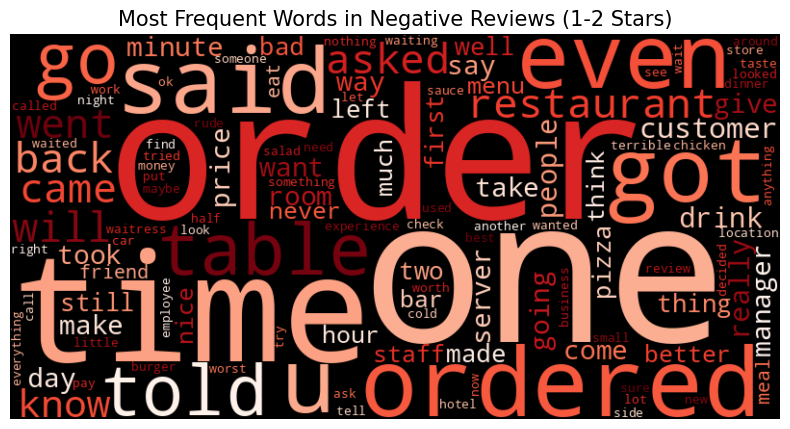

In [24]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# تنظیمات استاپ‌وردها (کلمات حذف شدنی)
stopwords = set(STOPWORDS)
stopwords.update(["br", "href", "good", "great", "food", "place", "service"])
# کلماتی مثل food یا place چون در همه نقدها هستند شاید ارزش اطلاعاتی نداشته باشند،
# می‌توانید بسته به نیاز این لیست را تغییر دهید.

def generate_wordcloud(text, title, background_color='white', colormap='viridis'):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color=background_color,
        stopwords=stopwords,
        min_font_size=10,
        colormap=colormap
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=15)
    plt.show()

print("Generating WordClouds...")

# 1. جدا کردن متن‌های مثبت و منفی
# فرض بر این است که df شما ستون‌های 'text' و 'label' را دارد
positive_reviews = " ".join(df[df['label'] == 1]['text'].astype(str).tolist())
negative_reviews = " ".join(df[df['label'] == 0]['text'].astype(str).tolist())

# 2. رسم ابر کلمات برای نظرات مثبت
print("Positive Reviews WordCloud:")
generate_wordcloud(positive_reviews, "Most Frequent Words in Positive Reviews (3-5 Stars)", background_color='white', colormap='viridis')

# 3. رسم ابر کلمات برای نظرات منفی
print("Negative Reviews WordCloud:")
generate_wordcloud(negative_reviews, "Most Frequent Words in Negative Reviews (1-2 Stars)", background_color='black', colormap='Reds')

In [16]:
# تابع تبدیل ستاره به برچسب
def create_sentiment_label(star):
    if star >= 3:
        return 1 # Positive
    else:
        return 0 # Negative

# اعمال تابع روی دیتاست
df['label'] = df['stars'].apply(create_sentiment_label)

# نمایش توزیع کلاس‌ها
print("Class Distribution:")
print(df['label'].value_counts())

# تقسیم داده‌ها به Train و Test
# 80% آموزش، 20% تست
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label'] # برای حفظ نسبت کلاس‌ها
)

print(f"Train size: {len(train_texts)}")
print(f"Test size: {len(test_texts)}")

Class Distribution:
label
1    40618
0     9382
Name: count, dtype: int64
Train size: 40000
Test size: 10000


## Simple Baseline Model (TF-IDF + Logistic Regression)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

print("Training Simple Baseline Model (TF-IDF + Logistic Regression)...")

# 1. ساخت پایپ‌لاین (ترکیب بردارساز و مدل)
# max_features=10000: فقط ۱۰ هزار کلمه پرتکرار را در نظر می‌گیرد تا مدل سبک بماند
pipeline_baseline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

# 2. آموزش مدل
pipeline_baseline.fit(train_texts, train_labels)

# 3. پیش‌بینی روی داده‌های تست
preds_baseline = pipeline_baseline.predict(test_texts)

print("Training complete.")

Training Simple Baseline Model (TF-IDF + Logistic Regression)...
Training complete.


## BERT: Tokenization

In [17]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# تبدیل داده‌ها به فرمت Dataset کتابخانه huggingface
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

# تابع توکنایزر
def preprocess_function(examples):
    # truncation=True برای بریدن متن‌های طولانی‌تر از ۵۱۲ توکن
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# اعمال توکنایزر روی کل دیتاست
print("Tokenizing datasets...")
encoded_train_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_test_dataset = test_dataset.map(preprocess_function, batched=True)

# ستون‌های غیرضروری را حذف می‌کنیم تا فقط input_ids, attention_mask و labels بمانند
encoded_train_dataset = encoded_train_dataset.remove_columns(["text"])
encoded_test_dataset = encoded_test_dataset.remove_columns(["text"])

# فرمت خروجی را به پایتورچ تغییر می‌دهیم
encoded_train_dataset.set_format("torch")
encoded_test_dataset.set_format("torch")

print("Tokenization complete.")

Tokenizing datasets...


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenization complete.


In [18]:
encoded_train_dataset

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 40000
})

## BERT: Model Implementation

In [19]:
# بارگذاری مدل برای طبقه‌بندی (2 کلاس: مثبت و منفی)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# تعریف متریک‌ها برای ارزیابی حین آموزش
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# تنظیمات آموزش
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",     # ارزیابی در پایان هر اپوک
    save_strategy="epoch",           # ذخیره مدل در پایان هر اپوک
    learning_rate=2e-5,              # نرخ یادگیری استاندارد برای BERT
    per_device_train_batch_size=32,  # بسته به حافظه GPU می‌توانید کم یا زیاد کنید (مثلا 8 یا 32)
    per_device_eval_batch_size=32,
    num_train_epochs=2,              # تعداد دورهای آموزش (برای BERT معمولا 2 تا 4 کافی است)
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"                 # عدم ارسال گزارش به wandb و ...
)

# ایجاد Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4107816926.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## BERT: Training Model

In [20]:
print("Starting training...")
trainer.train()
print("Training complete.")

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.171800,0.160901,0.931200,0.931928,0.931200,0.931533
2,0.118900,0.176095,0.935000,0.934505,0.935000,0.934730


Training complete.


## Evaluating Metrices

Evaluating on test set...



Yelp Sentiment Analysis Results (BERT)
Accuracy:  0.9350
Precision: 0.9345
Recall:    0.9350
F1-Score:  0.9347

Classification Report:
                      precision    recall  f1-score   support

Negative (1-2 stars)       0.83      0.82      0.82      1876
Positive (3-5 stars)       0.96      0.96      0.96      8124

            accuracy                           0.94     10000
           macro avg       0.90      0.89      0.89     10000
        weighted avg       0.93      0.94      0.93     10000



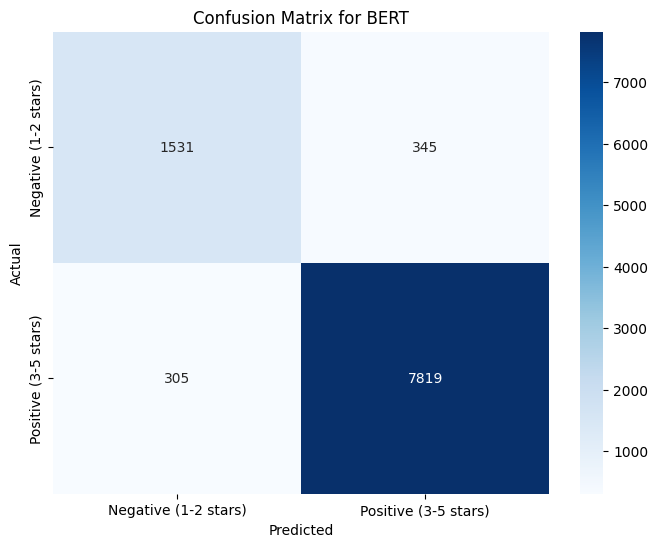

In [27]:
# پیش‌بینی روی داده‌های تست
print("Evaluating on test set...")
predictions_output = trainer.predict(encoded_test_dataset)
preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

# محاسبه دقیق معیارها
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted')
recall = recall_score(labels, preds, average='weighted')
f1 = f1_score(labels, preds, average='weighted')

print("\n" + "="*60)
print("Yelp Sentiment Analysis Results (BERT)")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# گزارش طبقه‌بندی کامل
target_names = ['Negative (1-2 stars)', 'Positive (3-5 stars)']
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=target_names))

# رسم ماتریس درهم‌ریختگی
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for BERT')
plt.show()


Baseline Model Results (TF-IDF + LogReg)
Accuracy:  0.9187
Precision: 0.9161
Recall:    0.9187
F1-Score:  0.9145

Classification Report (Baseline):
              precision    recall  f1-score   support

    Negative       0.87      0.67      0.76      1876
    Positive       0.93      0.98      0.95      8124

    accuracy                           0.92     10000
   macro avg       0.90      0.82      0.85     10000
weighted avg       0.92      0.92      0.91     10000



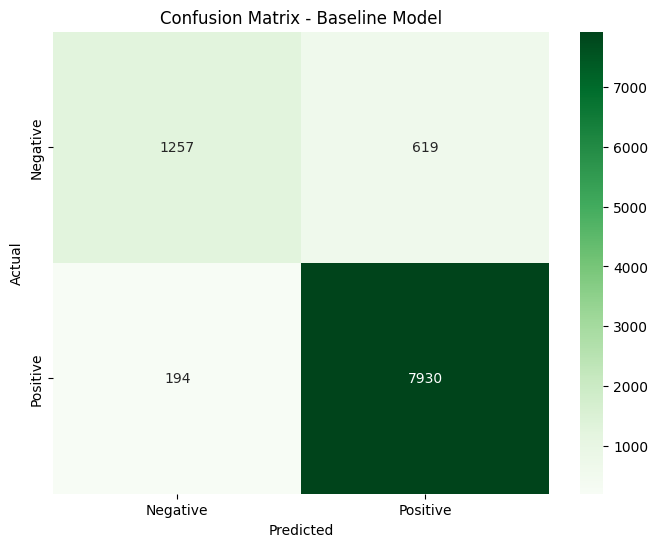

In [33]:
# محاسبه معیارها برای مدل ساده
acc_base = accuracy_score(test_labels, preds_baseline)
prec_base = precision_score(test_labels, preds_baseline, average='weighted')
rec_base = recall_score(test_labels, preds_baseline, average='weighted')
f1_base = f1_score(test_labels, preds_baseline, average='weighted')

print("\n" + "="*60)
print("Baseline Model Results (TF-IDF + LogReg)")
print("="*60)
print(f"Accuracy:  {acc_base:.4f}")
print(f"Precision: {prec_base:.4f}")
print(f"Recall:    {rec_base:.4f}")
print(f"F1-Score:  {f1_base:.4f}")

# گزارش کامل
print("\nClassification Report (Baseline):")
print(classification_report(test_labels, preds_baseline, target_names=['Negative', 'Positive']))

# رسم ماتریس درهم‌ریختگی برای مدل ساده
cm_base = confusion_matrix(test_labels, preds_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline Model')
plt.show()

## Model Prediction on reviews

In [22]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return "Positive" if predicted_class_id == 1 else "Negative"

# نمونه‌های تست دستی
samples = [
    "The food was amazing and the service was great!",
    "I hated this place. The food was cold and tasteless.",
    "It was okay, not the best but not the worst.",
    "Absolutely terrible experience, never coming back."
]

print("\n" + "="*60)
print("Manual Testing:")
print("="*60)
for sample in samples:
    print(f"Review: {sample}")
    print(f"Sentiment: {predict_sentiment(sample)}")
    print("-" * 30)


Manual Testing:
Review: The food was amazing and the service was great!
Sentiment: Positive
------------------------------
Review: I hated this place. The food was cold and tasteless.
Sentiment: Negative
------------------------------
Review: It was okay, not the best but not the worst.
Sentiment: Positive
------------------------------
Review: Absolutely terrible experience, never coming back.
Sentiment: Negative
------------------------------


## Cleaning data and train new Models

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Applying Advanced Cleaning (Handling negations like 'not_good')...

Common words found and removed from visualization (127 words):
['sauce', 'think', 'try', 'many', 'everything', 'next', 'served', 'husband', 'probably', 'never', 'staff', 'room', 'bit', 'right', 'shrimp', 'wanted', 'take', 'give', 'great', 'meal']

Generating Refined WordClouds...


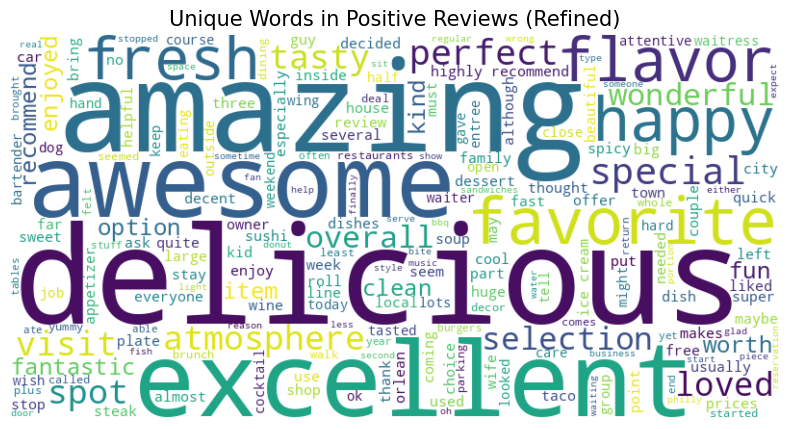

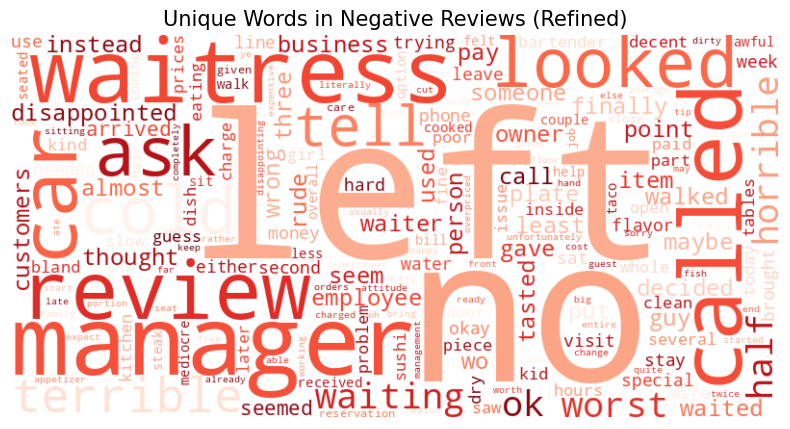

In [37]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# دانلود منابع (اگر ندارید)
nltk.download('stopwords')
nltk.download('punkt')

# 1. تنظیم لیست کلمات توقف (Stopwords)
stop_words = set(stopwords.words('english'))

# نکته مهم: کلمات منفی‌ساز را از لیست حذف می‌کنیم تا دور ریخته نشوند
negation_words = {'not', 'no', 'never', "n't", 'don', "don't", 'didn', "didn't", 'isn', "isn't", 'aren', "aren't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}
stop_words = stop_words - negation_words

# کلمات عمومی بی‌ارزش (Generic) که می‌خواهیم حذف کنیم
generic_words = {
    'food', 'place', 'restaurant', 'service', 'time', 'order', 'ordered',
    'back', 'go', 'went', 'came', 'got', 'us', 'would', 'really', 'also',
    'get', 'one', 'menu', 'even', 'table', 'experience', 'wait', 'people',
    'said', 'told', 'asked', 'customer', 'minutes', 'check', 'star', 'stars'
}
stop_words.update(generic_words)

# 2. تابع تمیزکاری با مدیریت نفی (Bigram Negation)
def clean_text_advanced(text):
    text = text.lower()
    tokens = word_tokenize(text)

    clean_tokens = []
    i = 0
    while i < len(tokens):
        word = tokens[i]

        # اگر کلمه حروف الفبا نیست، رد کن
        if not word.isalpha():
            i += 1
            continue

        # اگر کلمه منفی‌ساز است و کلمه بعدی وجود دارد
        if word in negation_words and i + 1 < len(tokens):
            next_word = tokens[i+1]
            if next_word.isalpha() and next_word not in stop_words:
                # ترکیب دو کلمه (مثلاً not_good)
                clean_tokens.append(f"{word}_{next_word}")
                i += 2 # پرش از روی کلمه بعدی چون ترکیب شد
                continue

        # حالت عادی
        if word not in stop_words:
            clean_tokens.append(word)

        i += 1

    return " ".join(clean_tokens)

print("Applying Advanced Cleaning (Handling negations like 'not_good')...")
df['cleaned_text'] = df['text'].apply(clean_text_advanced)


# 3. حذف هوشمند کلمات مشترک (Intersection Removal)
# هدف: کلماتی که هم در مثبت و هم در منفی زیاد تکرار شده‌اند را پیدا و حذف کنیم

# جدا کردن متن‌ها
pos_text = " ".join(df[df['label'] == 1]['cleaned_text'].astype(str).tolist()).split()
neg_text = " ".join(df[df['label'] == 0]['cleaned_text'].astype(str).tolist()).split()

# شمارش کلمات
pos_counts = Counter(pos_text)
neg_counts = Counter(neg_text)

# پیدا کردن 200 کلمه پرتکرار هر کدام
top_pos = set([word for word, count in pos_counts.most_common(200)])
top_neg = set([word for word, count in neg_counts.most_common(200)])

# پیدا کردن اشتراکات (کلماتی که در هر دو لیست هستند)
common_intersection = top_pos.intersection(top_neg)

print(f"\nCommon words found and removed from visualization ({len(common_intersection)} words):")
print(list(common_intersection)[:20]) # نمایش 20 تا نمونه

# اضافه کردن این کلمات مشترک به لیست حذف نهایی برای WordCloud
stopwords_for_wc = stop_words.union(common_intersection)
# همچنین کلمات مثبت عمومی مثل 'good', 'great', 'like' که در منفی‌ها نویز ایجاد می‌کنند را دستی اضافه می‌کنیم
stopwords_for_wc.update(['good', 'great', 'like', 'love', 'best', 'nice', 'better', 'well'])

# 4. رسم WordCloud نهایی
def plot_wordcloud_refined(text_list, title, colormap):
    text = " ".join(text_list)
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stopwords_for_wc, # استفاده از لیست استاپ‌وردهای جدید
        colormap=colormap,
        min_font_size=10,
        regexp=r"\w+(?:'\w+)?(?:_\w+)?" # این Regex اجازه می‌دهد کلمات ترکیبی مثل not_good هم دیده شوند
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=15)
    plt.show()

print("\nGenerating Refined WordClouds...")

# رسم برای مثبت
plot_wordcloud_refined(
    df[df['label'] == 1]['cleaned_text'].astype(str).tolist(),
    "Unique Words in Positive Reviews (Refined)",
    "viridis"
)

# رسم برای منفی
plot_wordcloud_refined(
    df[df['label'] == 0]['cleaned_text'].astype(str).tolist(),
    "Unique Words in Negative Reviews (Refined)",
    "Reds"
)

In [38]:
from sklearn.model_selection import train_test_split

print("Splitting CLEANED data...")

# استفاده از ستون cleaned_text به عنوان ورودی (X)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label'] # حفظ تعادل کلاس‌ها
)

print(f"Train size: {len(train_texts)}")
print(f"Test size: {len(test_texts)}")

Splitting CLEANED data...
Train size: 40000
Test size: 10000


Training Baseline Model on Advanced Cleaned Data...

Baseline Model Results (Advanced Cleaned Data)
Accuracy: 0.9211
F1-Score: 0.9173

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.68      0.76      1876
    Positive       0.93      0.98      0.95      8124

    accuracy                           0.92     10000
   macro avg       0.90      0.83      0.86     10000
weighted avg       0.92      0.92      0.92     10000



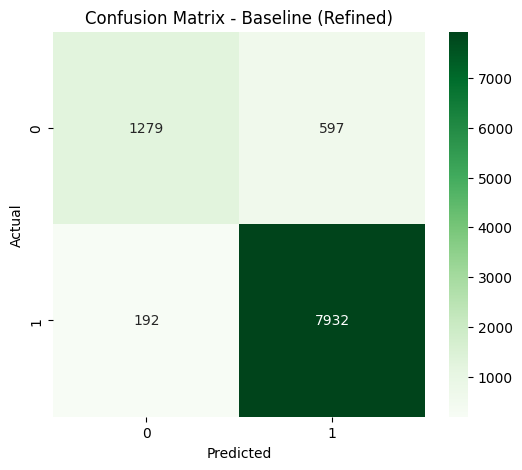

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Training Baseline Model on Advanced Cleaned Data...")

# 1. ساخت پایپ‌لاین
# تنظیمات TF-IDF:
# ngram_range=(1, 1): چون ما قبلا n-gram ها را دستی ساختیم (مثل not_good)، اینجا تک‌کلمه‌ای کافی است
# min_df=5: حذف کلمات خیلی خیلی نادر (نویز تایپی)
pipeline_clean = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, max_features=15000)),
    ('clf', LogisticRegression(solver='liblinear', C=1.0, random_state=42))
])

# 2. آموزش
pipeline_clean.fit(train_texts, train_labels)

# 3. پیش‌بینی
preds_clean_base = pipeline_clean.predict(test_texts)

# 4. نتایج
acc_base_clean = accuracy_score(test_labels, preds_clean_base)
f1_base_clean = f1_score(test_labels, preds_clean_base, average='weighted')

print("\n" + "="*50)
print("Baseline Model Results (Advanced Cleaned Data)")
print("="*50)
print(f"Accuracy: {acc_base_clean:.4f}")
print(f"F1-Score: {f1_base_clean:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, preds_clean_base, target_names=['Negative', 'Positive']))

# رسم ماتریس درهم‌ریختگی
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(test_labels, preds_clean_base), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Baseline (Refined)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [40]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# تنظیمات
model_name = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. توکنایزر
tokenizer = AutoTokenizer.from_pretrained(model_name)

# تبدیل داده‌ها به فرمت Dataset
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

def preprocess_function(examples):
    # پردازش متن‌های تمیز شده
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

print("Tokenizing Advanced Cleaned data for BERT...")
encoded_train = train_dataset.map(preprocess_function, batched=True)
encoded_test = test_dataset.map(preprocess_function, batched=True)

# فرمت‌دهی برای پایتورچ
encoded_train = encoded_train.remove_columns(["text"])
encoded_test = encoded_test.remove_columns(["text"])
encoded_train.set_format("torch")
encoded_test.set_format("torch")

# 2. مدل و متریک‌ها
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

# 3. تنظیمات آموزش (Training Arguments)
training_args = TrainingArguments(
    output_dir="./results_refined",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,  # تعداد دورهای آموزش
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# 4. ترینر (Trainer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 5. شروع آموزش
print("Starting BERT training on Refined Data...")
trainer.train()
print("Training complete.")

Using device: cuda
Tokenizing Advanced Cleaned data for BERT...


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-883080866.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting BERT training on Refined Data...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.187800,0.169075,0.929900,0.931131
2,0.136900,0.174321,0.932700,0.932707


Training complete.


Evaluating BERT...



BERT Model Results (Advanced Cleaned Data)
Accuracy: 0.9327
F1-Score: 0.9327
              precision    recall  f1-score   support

    Negative       0.82      0.82      0.82      1876
    Positive       0.96      0.96      0.96      8124

    accuracy                           0.93     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.93      0.93      0.93     10000



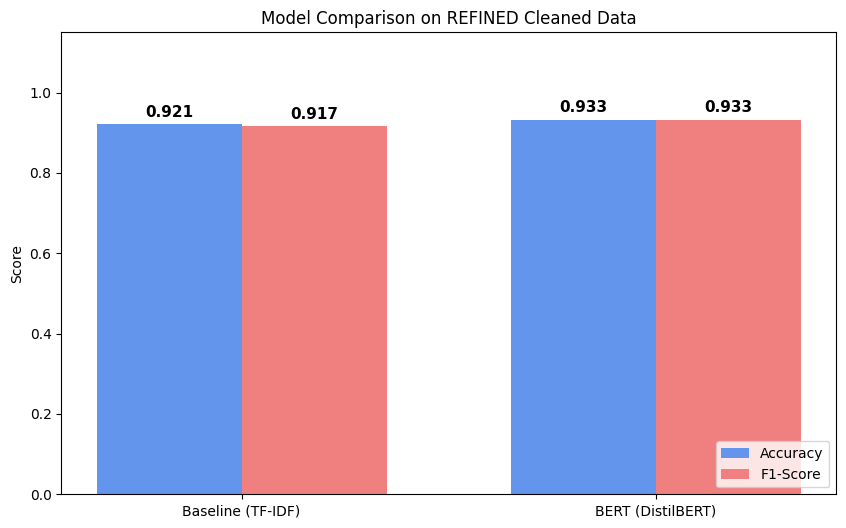

In [41]:
# 1. گرفتن پیش‌بینی‌های نهایی BERT
print("Evaluating BERT...")
preds_output = trainer.predict(encoded_test)
preds_bert = np.argmax(preds_output.predictions, axis=-1)
labels_bert = preds_output.label_ids

# محاسبه متریک‌های BERT
acc_bert = accuracy_score(labels_bert, preds_bert)
f1_bert = f1_score(labels_bert, preds_bert, average='weighted')

print("\n" + "="*50)
print("BERT Model Results (Advanced Cleaned Data)")
print("="*50)
print(f"Accuracy: {acc_bert:.4f}")
print(f"F1-Score: {f1_bert:.4f}")
print(classification_report(labels_bert, preds_bert, target_names=['Negative', 'Positive']))


# 2. رسم نمودار مقایسه‌ای
models_names = ['Baseline (TF-IDF)', 'BERT (DistilBERT)']
accuracies = [acc_base_clean, acc_bert]
f1_scores = [f1_base_clean, f1_bert]

x = np.arange(len(models_names))
width = 0.35

plt.figure(figsize=(10, 6))
rects1 = plt.bar(x - width/2, accuracies, width, label='Accuracy', color='cornflowerblue')
rects2 = plt.bar(x + width/2, f1_scores, width, label='F1-Score', color='lightcoral')

plt.ylabel('Score')
plt.title('Model Comparison on REFINED Cleaned Data')
plt.xticks(x, models_names)
plt.legend(loc='lower right')
plt.ylim(0, 1.15) # کمی فضای بیشتر در بالا

# نوشتن اعداد روی ستون‌ها
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.show()